# Tuning Parameters

To test which parameters work well for this algorithm, I ran a series of experiments. First, I loaded some training data and defined a simple `Flag` type to signal that a worker thread should stop.

In [1]:
import time
import queue
from threading import Thread

from evaluate_fitness import load_training_data
from genetic_algorithm import genetic_algorithm
from solution import Solution
from tree import Tree


training_data = load_training_data("data/cetdl1772small.dat")


class Flag:
    def __init__(self):
        self._set = False
    
    def set(self):
        self._set = True
    
    def __bool__(self):
        return self._set

# Calculating Parameters

We choose 3 parameters to tune, and 4 values for each parameter. We run each parameter setting, for each parameter, 100 times, and gather the 100 fitnesses achieved for each value of each parameter.

Choosing (fairly conservatively):
* Time budget of 20 seconds
* 3 parameters to alter
* 4 values for each parameter

This gives a runtime of $ 3 * 4 * 20 * 100 = 24000 $ seconds, or about six hours and forty minutes. Clearly we need to use some parallelism to get results in any reasonable timeframe. To achieve this we use the Multiprocessing library.

Firstly, we define a function `run_test` which returns the best fitness found after a 20-second run of one set of parameters.

In [2]:
def run_test(time_budget=20, pop_size=100, input_size=-1, iterations=2**100, 
             fraction_parents=0.1, p_simplify=0.01, num_sweeps=3, wrong_choice=0.4,
             mutation_crossover_ratio=0.5, mutation_replacement_ratio=0.5):

    # Perform the GA in a separate thread.
    stop_flag = Flag()
    results_queue = queue.LifoQueue()
    target = lambda: genetic_algorithm(
        pop_size, input_size, iterations, training=training_data, results_queue=results_queue,
        stop_flag=stop_flag,
        p_simplify=p_simplify, num_sweeps=num_sweeps, wrong_choice=wrong_choice,
        mutation_crossover_ratio=mutation_crossover_ratio, fraction_parents=fraction_parents,
        mutation_replacement_ratio=mutation_replacement_ratio
    )
    computation_thread = Thread(target=target, daemon=True)  # Allow exiting when the timer runs out.
    computation_thread.start()

    # Wait `time_budget` seconds, then take the latest result.
    time.sleep(time_budget-0.1)
    best = results_queue.get_nowait()
    stop_flag.set()

    fitness = best.evaluate_fitness_against(training_data)
    return fitness

We define some default arguments as the "control" variables, and create our multiprocessing `Pool` of workers. These are an abstraction over OS threads, so I've created 8 as `multiprocessing.cpu_count()` reports that my system has 8 usable cores.

In [3]:
import time
import statistics as stats
from multiprocessing import Pool

# Default arguments for test runner.
args = {
    "fraction_parents": 0.2,
    "p_simplify": 0.01,
    "mutation_crossover_ratio": 0.4,
}


ITERATIONS = 100
WORKERS = 8
pool = Pool(WORKERS)

# Test Parameter: Fraction of Parents from Population

For this test, we tweak the fraction of individuals which are chosen as parents – that is, targets for mutation and crossover. (Note: the parents themselves are left in the pool; the mutated children are newly created. This means we might expect the average diversity to be higher using a lower fraction of the population as parents.)

In [4]:
from test_runners import test_runner
start = time.perf_counter()

parent_fraction_results = {}
for fraction in (0.1, 0.2, 0.3, 0.4):
    fitnesses = list(pool.imap_unordered(
        test_runner,
        ((run_test, {**args, "fraction_parents": fraction}) for _ in range(ITERATIONS))
    ))
    stddev = stats.stdev(fitnesses)
    mean = stats.mean(fitnesses)
    parent_fraction_results[fraction] = (fitnesses, stddev, mean)

print(f"Running {4 * ITERATIONS} tests at 20s each on {WORKERS} workers took {(time.perf_counter() - start):.1f}s")

Running 400 tests at 20s each on 8 workers took 1039.2s


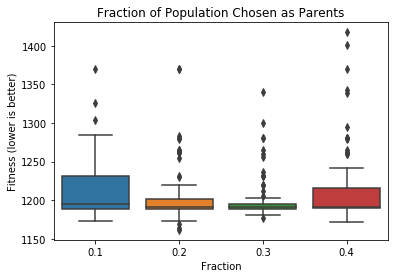

In [41]:
from seaborn import boxplot

data = [
    v[0] for v in (parent_fraction_results[k] 
        for k in sorted(parent_fraction_results.keys()))
]

_ = boxplot(data=data).set(
    xlabel="Fraction",
    ylabel="Fitness (lower is better)",
    xticklabels=list(parent_fraction_results.keys()),
    title="Fraction of Population Chosen as Parents"
)

The lowest mean of the group is with a fraction of 0.2, while the lower quartile is lowest with a fraction of 0.3. 0.1 here seems like a bad choice, with a much wider interquartile range. 0.3 seems like a slightly better choice here, although the difference is not large. We can see this in more detail by removing outliers:

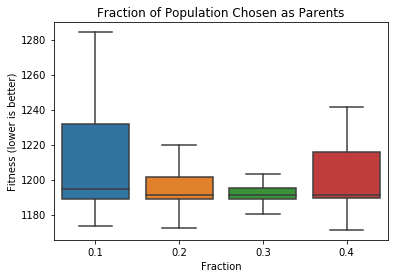

In [43]:
_ = boxplot(data=data, showfliers=False).set(
    xlabel="Fraction",
    ylabel="Fitness (lower is better)",
    xticklabels=list(parent_fraction_results.keys()),
    title="Fraction of Population Chosen as Parents"
)

The standard deviations of the fitness distributions given by each population fraction are shown below:

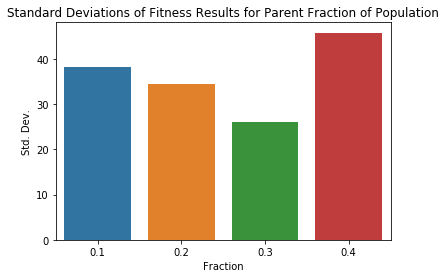

In [31]:
from seaborn import barplot

ys = [v[1] for v in (parent_fraction_results[k]
            for k in sorted(parent_fraction_results.keys()))]

_ = barplot(x=list(parent_fraction_results.keys()), y=ys, ci=None).set(
    xlabel="Fraction", ylabel="Std. Dev.", title="Standard Deviations of Fitness Results for Parent Fraction of Population"
)

# Test Parameter: Probability of Simplifying Solutions

We introduced a parameter controlling the probability that an individual solution would be "simplified", i.e. its purely mathematical subtrees evaluated and replaced with simple numerical nodes, in each generation. The expectation was that ramping up this parameter would lead to a greater diversity of solutions by decreasing the average size of the tree, and therefore making it more probably that nodes closer to the root of the tree would be mutated.

In [6]:
from test_runners import test_runner
start = time.perf_counter()

p_simplify_results = {}
for p_simplify in (0, 0.01, 0.5, 1):
    fitnesses = list(pool.imap_unordered(
        test_runner,
        ((run_test, {**args, "p_simplify": p_simplify}) for _ in range(ITERATIONS))
    ))
    stddev = stats.stdev(fitnesses)
    mean = stats.mean(fitnesses)
    p_simplify_results[p_simplify] = (fitnesses, stddev, mean)

print(f"Running {4 * ITERATIONS} tests at 20s each on {WORKERS} workers took {(time.perf_counter() - start):.1f}s")

Running 400 tests at 20s each on 8 workers took 1038.3s


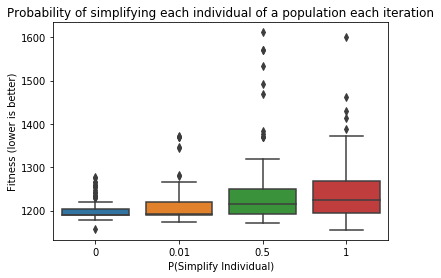

In [7]:
data = [
    v[0] for v in (p_simplify_results[k] 
        for k in sorted(p_simplify_results.keys()))
]

_ = boxplot(data=data).set(
    xlabel="P(Simplify Individual)",
    ylabel="Fitness (lower is better)",
    xticklabels=list(p_simplify_results.keys()),
    title="Probability of simplifying each individual of a population each iteration"
)

The results of this somewhat discredit the hypothesis: simplifying individuls fairly reliably increases the interquartile range upwards. The best parameter to choose here is clearly 0, meaning that the simplification is a net negative. Perhaps this is just a feature of the fact that simplification brings increased computational overhead, so fewer iterations were possible in the 20-second window.

Outliers are a major feature in this dataset and compress the box plots down making them difficult to compare. Drawing the box plots without outliers:

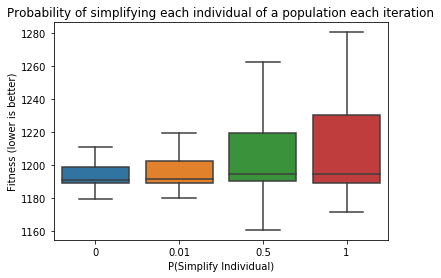

In [20]:
_ = boxplot(data=data, showfliers=False).set(
    xlabel="P(Simplify Individual)",
    ylabel="Fitness (lower is better)",
    xticklabels=list(p_simplify_results.keys()),
    title="Probability of simplifying each individual of a population each iteration"
)

Below are also given the standard deviations of the results.

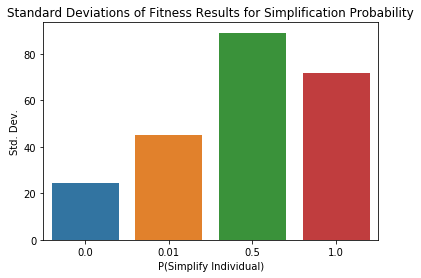

In [33]:
ys = [v[1] for v in (p_simplify_results[k]
            for k in sorted(p_simplify_results.keys()))]

_ = barplot(x=list(p_simplify_results.keys()), y=ys, ci=None).set(
    xlabel="P(Simplify Individual)", ylabel="Std. Dev.", title="Standard Deviations of Fitness Results for Simplification Probability"
)

# Test Parameter: Probability of Mutating vs. Crossover

This parameter is a probability to decide between between mutating the "next" parent node, or performing crossover on the next two parent nodes, to yield one or two children respectively.

In [8]:
from test_runners import test_runner
start = time.perf_counter()

mutation_crossover_ratio_results = {}
for mutation_crossover_ratio in (0.2, 0.4, 0.6, 0.8):
    fitnesses = list(pool.imap_unordered(
        test_runner,
        ((run_test, {**args, "mutation_crossover_ratio": mutation_crossover_ratio}) for _ in range(ITERATIONS))
    ))
    stddev = stats.stdev(fitnesses)
    mean = stats.mean(fitnesses)
    mutation_crossover_ratio_results[mutation_crossover_ratio] = (fitnesses, stddev, mean)

print(f"Running {4 * ITERATIONS} tests at 20s each on {WORKERS} workers took {(time.perf_counter() - start):.1f}s")

Running 400 tests at 20s each on 8 workers took 1038.3s


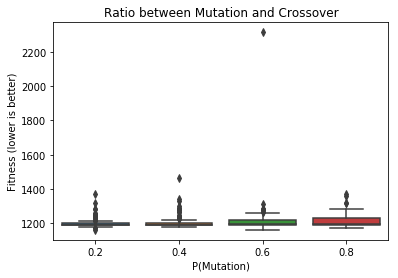

In [9]:
data = [
    v[0] for v in (mutation_crossover_ratio_results[k] 
        for k in sorted(mutation_crossover_ratio_results.keys()))
]

_ = boxplot(data=data).set(
    xlabel="P(Mutation)",
    ylabel="Fitness (lower is better)",
    xticklabels=list(mutation_crossover_ratio_results.keys()),
    title="Ratio between Mutation and Crossover"
)

This graph is very hard to interpret with a huge outlier in the 0.6 category. Removing outliers, we see a different picture:

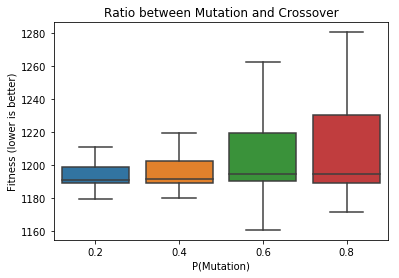

In [19]:
_ = boxplot(data=data, showfliers=False).set(
    xlabel="P(Mutation)",
    ylabel="Fitness (lower is better)",
    xticklabels=list(mutation_crossover_ratio_results.keys()),
    title="Ratio between Mutation and Crossover",
)

A lower mutation ratio here (emphasizing crossover) seems to indicate a much more reliably compact distribution of fitnesses – although the lower quartile and mean is very similar across each mutation probability. Here, 0.2 seems to be the best parameter to choose as it decreases the interquartile range and makes the algorithm somewhat more predictable in its output fitnesses.

We also show the standard deviations of the fitness results of different mutation ratios.

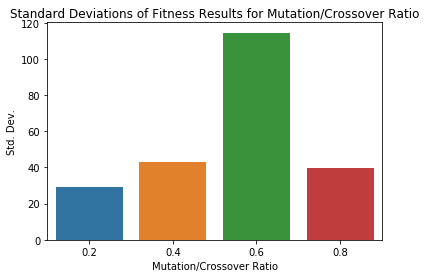

In [34]:
from seaborn import barplot

ys = [v[1] for v in (mutation_crossover_ratio_results[k]
            for k in sorted(mutation_crossover_ratio_results.keys()))]

_ = barplot(x=list(mutation_crossover_ratio_results.keys()), y=ys, ci=None).set(
    xlabel="Mutation/Crossover Ratio", ylabel="Std. Dev.", title="Standard Deviations of Fitness Results for Mutation/Crossover Ratio"
)

In [35]:
# Make sure the threadpool of workers is fully closed and completed.
pool.close()
pool.join()

# Full Experimental Data

Below follows the raw experimental data used in plotting the graphs above.

In [16]:
print(parent_fraction_results)

{0.1: ([1201.2872872872872, 1189.0478282473264, 1197.6699627206146, 1245.2869179677014, 1188.4526320955279, 1191.017017017017, 1259.8214188913873, 1231.423287057698, 1188.7467467467468, 1188.601956919985, 1200.62113610939, 1191.017017017017, 1183.2903641270345, 1182.7911251348123, 1202.500506455792, 1193.2448792229193, 1194.4764764764764, 1230.5764702128074, 1194.4764764764764, 1194.4764764764764, 1188.5795275252685, 1283.853828891366, 1186.6486486486488, 1188.7178685485221, 1195.9061510490083, 1188.7467467467468, 1188.8818818818818, 1194.4764764764764, 1280.098098098098, 1191.017017017017, 1211.833569954409, 1304.2372283017128, 1194.4764764764764, 1265.7494806525276, 1280.0980440941373, 1325.864367435587, 1232.9022374633496, 1179.9997411296035, 1185.851905197883, 1173.575461317038, 1265.1890690674963, 1187.6020506151422, 1218.346047589547, 1201.2872872872872, 1188.629239225215, 1194.4764764764764, 1188.764157461916, 1184.5845845845845, 1188.7467467467468, 1189.2440079116723, 1213.9528

In [17]:
print(p_simplify_results)

{0: ([1207.2443331494105, 1188.8280411914889, 1231.6926926926926, 1201.2872872872872, 1246.452185629658, 1265.1890690674963, 1242.1220435373577, 1186.2304370268655, 1190.6116116116116, 1230.5764702128074, 1189.6124058035823, 1189.9163214008133, 1189.6772377076945, 1230.430458795778, 1241.3805219661567, 1186.3730830212546, 1188.6760330056227, 1187.0, 1188.7118086958833, 1218.0710710710712, 1188.7467467467468, 1191.017017017017, 1156.428616116116, 1219.5575575575576, 1189.9229629629629, 1201.2872872872872, 1230.5248190625912, 1202.4126553506885, 1190.4405284376812, 1188.764157461916, 1190.6116116116116, 1229.935935935936, 1188.604754195925, 1201.2872872872872, 1188.153643762082, 1201.2872872872872, 1188.6030826695105, 1259.6656656656658, 1188.764157461916, 1182.8780870853625, 1189.631716313822, 1215.0444728218997, 1193.9286702084135, 1200.3882733000696, 1217.3703156033994, 1190.6116116116116, 1188.8818818818818, 1191.3912241066027, 1189.1309912970487, 1190.6116116116116, 1190.61161161161

In [15]:
print(mutation_crossover_ratio_results)

{0.2: ([1231.6926926926926, 1194.4764764764764, 1202.058386017482, 1162.0400400400401, 1202.058386017482, 1184.1539748336816, 1180.7094872650428, 1183.296714166527, 1209.9734509153816, 1257.4725470902106, 1189.0305889178726, 1185.2161843050317, 1188.764157461916, 1183.8745820506927, 1195.4366380768956, 1188.7727170785176, 1194.4764764764764, 1190.904621641286, 1191.017017017017, 1194.4764764764764, 1188.764157461916, 1191.017017017017, 1190.2573105363078, 1204.8230502883807, 1190.6116116116116, 1245.8278278278278, 1280.098098098098, 1188.7467467467468, 1188.577298179942, 1188.764157461916, 1188.6914814479858, 1218.5568824556246, 1188.764157461916, 1194.8536882035546, 1201.2872872872872, 1188.5818598284397, 1236.5374246890115, 1213.9436369769762, 1189.3713713713714, 1201.2872872872872, 1194.4764764764764, 1190.6116116116116, 1318.7004865408596, 1194.4764764764764, 1191.8775694080146, 1188.7467467467468, 1198.4429998218916, 1199.5579210850153, 1218.7024539241645, 1179.2889766584324, 1195

# Other Possible Tests

I've included some code for other slightly less important tests which don't affect the result as much. These include tweaking the number of sweeps used in stochastic-sorting, the probabilities of using one kind of mutation over the other, and the probability of making a "wrong" choice during stochastic-sorting.

In [11]:
# mutation_replacement_ratio_results = {}

# for mutation_replacement_ratio in (0, 0.25, 0.5, 0.75, 1):
#     fitnesses = [
#         run_test(**{**args, "mutation_replacement_ratio": mutation_replacement_ratio})
#         for _ in range(ITERATIONS)
#     ]
#     stddev = stats.stdev(fitnesses)
#     mean = stats.mean(fitnesses)
#     mutation_replacement_ratio_results[mutation_replacement_ratio] = (fitnesses, stddev, mean)

In [12]:
# num_sweeps_results = {}

# for num_sweeps in (0, 1, 2, 4, 8):
#     fitnesses = [
#         run_test(**{**args, "num_sweeps": num_sweeps})
#         for _ in range(ITERATIONS)
#     ]
#     stddev = stats.stdev(fitnesses)
#     mean = stats.mean(fitnesses)
#     num_sweeps_results[num_sweeps] = (fitnesses, stddev, mean)

In [13]:
# p_wrong_choice_results = {}

# for p_wrong_choice in (0, 0.1, 0.25, 0.4, 0.5):
#     fitnesses = [
#         run_test(**{**args, "wrong_choice": p_wrong_choice})
#         for _ in range(ITERATIONS)
#     ]
#     stddev = stats.stdev(fitnesses)
#     mean = stats.mean(fitnesses)
#     p_wrong_choice_results[p_wrong_choice] = (fitnesses, stddev, mean)